<a href="https://colab.research.google.com/github/Jaimemorillo/Pointwise-ML-Ranking/blob/main/Pointwise_LOINC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNetCV, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tqdm.notebook import tqdm
tqdm.pandas()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load Data

In [63]:
df_glucose = pd.read_csv('loinc_dataset-glucose-in-blood.csv', sep=';')
df_bilirubin = pd.read_csv('loinc_dataset-bilirubin-in-plasma.csv', sep=';')
df_white_blood_cells = pd.read_csv('loinc_dataset-white-blood-cells-count.csv', sep=';')

In [64]:
df = pd.concat([df_glucose, df_bilirubin, df_white_blood_cells])
df = df.reset_index(drop=True)

In [65]:
drop_columns = ['loinc_num', 'component']
df = df.drop(drop_columns, axis=1)

df = pd.get_dummies(df, columns=['system', 'property'], drop_first=True)

In [66]:
df

,long_common_name,label_binary,label_3_cat,query,system_Bld^BPU,system_Calculus,system_Dose,system_Isolate,system_Plas,system_Plr fld,...,property_MSCnc,property_NCnc,property_NFr,property_Num,property_PrThr,property_SCnc,property_Susc,property_Temp,property_Type,property_VFr
0,C reactive protein [Mass/volume] in Serum or P...,0,0,GLUCOSE IN BLOOD,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bicarbonate [Moles/volume] in Blood,0,1,GLUCOSE IN BLOOD,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Rh [Type] in Blood,0,1,GLUCOSE IN BLOOD,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,Trimethoprim+Sulfamethoxazole [Susceptibility],0,0,GLUCOSE IN BLOOD,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,Bilirubin.total [Mass/volume] in Serum or Plasma,0,0,GLUCOSE IN BLOOD,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,Monocytes [#/volume] in Blood,1,1,WHITE BLOOD CELLS COUNT,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
197,Major crossmatch [interpretation],0,0,WHITE BLOOD CELLS COUNT,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198,Ampicillin [Susceptibility],0,0,WHITE BLOOD CELLS COUNT,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
199,Alanine aminotransferase [Enzymatic activity/v...,0,0,WHITE BLOOD CELLS COUNT,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


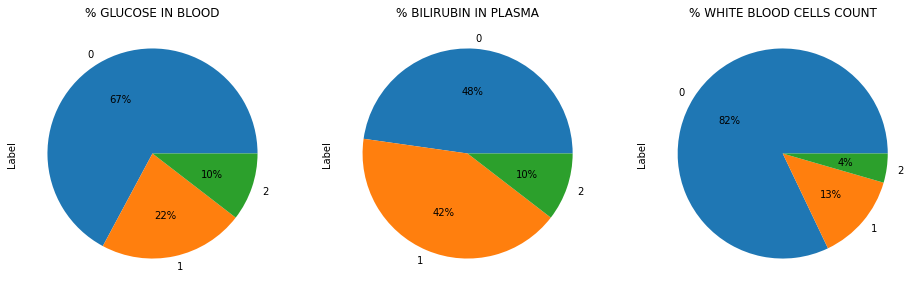

In [67]:
fig, axes = plt.subplots(1,3, figsize=(16, 5))
plot1 = df[df['query']=='GLUCOSE IN BLOOD'].label_3_cat.value_counts(normalize=True).plot.pie(autopct='%1.0f%%', 
                                                                                      ax = axes[0], 
                                                                                      title='% GLUCOSE IN BLOOD', 
                                                                                      ylabel='Label')
plot2 = df[df['query']=='BILIRUBIN IN PLASMA'].label_3_cat.value_counts(normalize=True).plot.pie(autopct='%1.0f%%', 
                                                                                      ax = axes[1], 
                                                                                      title='% BILIRUBIN IN PLASMA', 
                                                                                      ylabel='Label')
plot3 = df[df['query']=='WHITE BLOOD CELLS COUNT'].label_3_cat.value_counts(normalize=True).plot.pie(autopct='%1.0f%%', 
                                                                                      ax = axes[2], 
                                                                                      title='% WHITE BLOOD CELLS COUNT', 
                                                                                      ylabel='Label')

# Text Processing

In [69]:
class Normalizer:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.ps = PorterStemmer() # Create Stemmer
        self.word_net = WordNetLemmatizer() #Create Lemmatizer
    
    def remove_punct(self, text):
        text = text.lower() # To lower case
        text = re.sub('\W', ' ', text) # Replace any character which is not a word character
        text = re.sub('\s+', ' ', text) # Replace any whitespace character
        text = re.sub(' +', ' ', text) # Replace multiple whitespaces
        text = text.strip() # Delete sorrounding whitespaces
        return text
    
    def tokenize(self, text):
        return word_tokenize(text)
    
    def remove_stop_words(self, tokens):
        return [word for word in tokens if not word in self.stop_words] 
    
    def stemming(self, tokens):
        return [self.ps.stem(word) for word in tokens]
    
    def lemmatize(self, tokens):
        return [self.word_net.lemmatize(word) for word in tokens]
    
    def return_sentences(self, tokens):
        return " ".join(tokens)
    
    def clean_all(self, text):
        text = self.remove_punct(text)
        tokens = self.tokenize(text)
        tokens = self.remove_stop_words(tokens)
        tokens = self.stemming(tokens)
        text = self.return_sentences(tokens)
        return text

In [70]:
df_final = df.copy()

In [71]:
norm = Normalizer()
df_final['long_common_name'] = df_final['long_common_name'].progress_apply(lambda x: norm.clean_all(x))

  0%|          | 0/201 [00:00<?, ?it/s]

In [72]:
df_final

,long_common_name,label_binary,label_3_cat,query,system_Bld^BPU,system_Calculus,system_Dose,system_Isolate,system_Plas,system_Plr fld,...,property_MSCnc,property_NCnc,property_NFr,property_Num,property_PrThr,property_SCnc,property_Susc,property_Temp,property_Type,property_VFr
0,c reactiv protein mass volum serum plasma,0,0,GLUCOSE IN BLOOD,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,bicarbon mole volum blood,0,1,GLUCOSE IN BLOOD,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,rh type blood,0,1,GLUCOSE IN BLOOD,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,trimethoprim sulfamethoxazol suscept,0,0,GLUCOSE IN BLOOD,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,bilirubin total mass volum serum plasma,0,0,GLUCOSE IN BLOOD,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,monocyt volum blood,1,1,WHITE BLOOD CELLS COUNT,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
197,major crossmatch interpret,0,0,WHITE BLOOD CELLS COUNT,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198,ampicillin suscept,0,0,WHITE BLOOD CELLS COUNT,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
199,alanin aminotransferas enzymat activ volum ser...,0,0,WHITE BLOOD CELLS COUNT,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
X = df_final.drop(['label_binary','label_3_cat'], axis=1)
y = df_final['label_3_cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=1, 
                                                    stratify=df_final[['label_3_cat', 'query']])
print('Shape train: ' + str(X_train.shape))
print('Shape test: ' + str(X_test.shape))

Shape train: (160, 31)
Shape test: (41, 31)


In [74]:
tfidf = TfidfVectorizer(max_df=1.0, min_df=5, use_idf=True, smooth_idf=True, sublinear_tf=True)
X_train_enc = tfidf.fit_transform(X_train['long_common_name'])
X_test_enc = tfidf.transform(X_test['long_common_name'])

X_train_enc = pd.DataFrame.sparse.from_spmatrix(X_train_enc, index = X_train.index)
X_test_enc = pd.DataFrame.sparse.from_spmatrix(X_test_enc, index = X_test.index)

print('Size of the Vocabulary: ' + str(X_train_enc.shape[1]))
print('Original: ' + X_train.iloc[0, 0])
print('Encoded: ' + str(X_train_enc.iloc[0].to_numpy()))

Size of the Vocabulary: 33
Original: carbon dioxid total mole volum serum plasma
Encoded: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.54019715 0.         0.
 0.         0.54019715 0.         0.         0.         0.
 0.         0.         0.         0.3192227  0.22697311 0.
 0.         0.         0.         0.22697311 0.         0.41682726
 0.         0.         0.19414527]


In [75]:
X_train = X_train.join(X_train_enc)
X_train_enc['query'] = X_train['query']
X_test = X_test.join(X_test_enc)
X_test_enc['query'] = X_test['query']

In [76]:
def query_similarity(documents, query):
  query = norm.clean_all(query)
  query_enc = tfidf.transform([query])

  documents_similarity = cosine_similarity(query_enc, documents)
  documents_similarity = documents_similarity.T

  return documents_similarity

In [77]:
X_train_enc_glucose = X_train_enc[X_train_enc['query']=='GLUCOSE IN BLOOD'].drop('query', axis=1)
X_train_enc_glucose['query_similarity'] = query_similarity(X_train_enc_glucose, 'GLUCOSE IN BLOOD')

X_train_enc_bilirubin = X_train_enc[X_train_enc['query']=='BILIRUBIN IN PLASMA'].drop('query', axis=1)
X_train_enc_bilirubin['query_similarity'] = query_similarity(X_train_enc_bilirubin, 'BILIRUBIN IN PLASMA')

X_train_enc_white = X_train_enc[X_train_enc['query']=='WHITE BLOOD CELLS COUNT'].drop('query', axis=1)
X_train_enc_white['query_similarity'] = query_similarity(X_train_enc_white, 'WHITE BLOOD CELLS COUNT')

In [78]:
X_test_enc_glucose = X_test_enc[X_test_enc['query']=='GLUCOSE IN BLOOD'].drop('query', axis=1)
X_test_enc_glucose['query_similarity'] = query_similarity(X_test_enc_glucose, 'GLUCOSE IN BLOOD')

X_test_enc_bilirubin = X_test_enc[X_test_enc['query']=='BILIRUBIN IN PLASMA'].drop('query', axis=1)
X_test_enc_bilirubin['query_similarity'] = query_similarity(X_test_enc_bilirubin, 'BILIRUBIN IN PLASMA')

X_test_enc_white = X_test_enc[X_test_enc['query']=='WHITE BLOOD CELLS COUNT'].drop('query', axis=1)
X_test_enc_white['query_similarity'] = query_similarity(X_test_enc_white, 'WHITE BLOOD CELLS COUNT')

In [79]:
X_train_enc = pd.concat([X_train_enc_glucose, X_train_enc_bilirubin, X_train_enc_white])
X_train = X_train.join(X_train_enc['query_similarity'])

In [80]:
X_test_enc = pd.concat([X_test_enc_glucose, X_test_enc_bilirubin, X_test_enc_white])
X_test = X_test.join(X_test_enc['query_similarity'])

# Regression

In [81]:
reg = ElasticNetCV(cv=X_train.shape[0], random_state=1) #Leave one out
reg.fit(X_train.drop(['long_common_name', 'query'], axis=1).values, y_train)

ElasticNetCV(cv=160, random_state=1)

In [82]:
preds = reg.predict(X_test.drop(['long_common_name', 'query'], axis=1).values)

In [83]:
results = {
    'name': X_test['long_common_name'],
    'real' : y_test,
    'prob' : preds,
    'query': X_test['query']
}

results = pd.DataFrame(results)

In [84]:
results[results['query']=='GLUCOSE IN BLOOD'].sort_values('prob', ascending=False)

,name,real,prob,query
12,glucos mole volum urin,2,1.643936,GLUCOSE IN BLOOD
22,leukocyt volum blood,1,1.049274,GLUCOSE IN BLOOD
1,bicarbon mole volum blood,1,0.857432,GLUCOSE IN BLOOD
29,calcium ioniz mole volum blood,1,0.674254,GLUCOSE IN BLOOD
0,c reactiv protein mass volum serum plasma,0,0.266075,GLUCOSE IN BLOOD
49,carcinoembryon ag mass volum serum plasma,0,0.266075,GLUCOSE IN BLOOD
30,albumin mass volum serum plasma,0,0.266075,GLUCOSE IN BLOOD
13,amylas enzymat activ volum serum plasma,0,0.261767,GLUCOSE IN BLOOD
42,tyrosin aminotransferas mass volum plasma,0,0.187715,GLUCOSE IN BLOOD
24,bodi temperatur,0,0.183406,GLUCOSE IN BLOOD


In [85]:
results[results['query']=='BILIRUBIN IN PLASMA'].sort_values('prob', ascending=False)

,name,real,prob,query
104,bilirubin total mass volum synovi fluid,2,1.109554,BILIRUBIN IN PLASMA
100,cortisol mass volum serum plasma,1,0.822697,BILIRUBIN IN PLASMA
78,c reactiv protein mass volum serum plasma high...,1,0.640422,BILIRUBIN IN PLASMA
120,fast glucos mass mole volum serum plasma,1,0.632907,BILIRUBIN IN PLASMA
107,indirect antiglobulin test complement specif r...,1,0.598160,BILIRUBIN IN PLASMA
119,calcium mole volum correct albumin serum plasma,1,0.590348,BILIRUBIN IN PLASMA
129,aspart aminotransferas enzymat activ volum ser...,1,0.533433,BILIRUBIN IN PLASMA
73,methicillin resist staphylococcu aureu presenc...,0,0.183406,BILIRUBIN IN PLASMA
77,bodi temperatur,0,0.183406,BILIRUBIN IN PLASMA
83,rh type blood,0,0.083686,BILIRUBIN IN PLASMA


In [86]:
results[results['query']=='WHITE BLOOD CELLS COUNT'].sort_values('prob', ascending=False)

,name,real,prob,query
148,leukocyt volum blood,2,1.886583,WHITE BLOOD CELLS COUNT
152,bicarbon mole volum blood,1,1.479994,WHITE BLOOD CELLS COUNT
150,calcium ioniz mole volum blood,1,1.122866,WHITE BLOOD CELLS COUNT
172,blood group antibodi screen presenc serum plasma,0,1.001549,WHITE BLOOD CELLS COUNT
156,blood product unit id,0,0.763441,WHITE BLOOD CELLS COUNT
161,chlorid mole volum serum plasma,0,0.280203,WHITE BLOOD CELLS COUNT
174,cortisol mass volum serum plasma,0,0.266075,WHITE BLOOD CELLS COUNT
151,amylas enzymat activ volum serum plasma,0,0.261767,WHITE BLOOD CELLS COUNT
178,alkalin phosphatas enzymat activ volum serum p...,0,0.261767,WHITE BLOOD CELLS COUNT
189,tyrosin aminotransferas mass volum plasma,0,0.187715,WHITE BLOOD CELLS COUNT


# Classification

In [87]:
clf = LogisticRegressionCV(cv=14, random_state=1, max_iter=1000) # the least populated class in y has only 14 members
clf.fit(X_train.drop(['long_common_name', 'query'], axis=1).values, y_train)

LogisticRegressionCV(cv=14, max_iter=1000, random_state=1)

In [88]:
preds = clf.predict(X_test.drop(['long_common_name', 'query'], axis=1).values)

In [89]:
results = {
    'name': X_test['long_common_name'],
    'real' : y_test,
    'prob' : preds,
    'query': X_test['query']
}

results = pd.DataFrame(results)

In [90]:
results[results['query']=='GLUCOSE IN BLOOD'].sort_values('prob', ascending=False)

,name,real,prob,query
12,glucos mole volum urin,2,2,GLUCOSE IN BLOOD
29,calcium ioniz mole volum blood,1,1,GLUCOSE IN BLOOD
1,bicarbon mole volum blood,1,1,GLUCOSE IN BLOOD
22,leukocyt volum blood,1,1,GLUCOSE IN BLOOD
3,trimethoprim sulfamethoxazol suscept,0,0,GLUCOSE IN BLOOD
11,ampicillin suscept,0,0,GLUCOSE IN BLOOD
0,c reactiv protein mass volum serum plasma,0,0,GLUCOSE IN BLOOD
49,carcinoembryon ag mass volum serum plasma,0,0,GLUCOSE IN BLOOD
42,tyrosin aminotransferas mass volum plasma,0,0,GLUCOSE IN BLOOD
24,bodi temperatur,0,0,GLUCOSE IN BLOOD


In [91]:
results[results['query']=='BILIRUBIN IN PLASMA'].sort_values('prob', ascending=False)

,name,real,prob,query
104,bilirubin total mass volum synovi fluid,2,2,BILIRUBIN IN PLASMA
100,cortisol mass volum serum plasma,1,1,BILIRUBIN IN PLASMA
129,aspart aminotransferas enzymat activ volum ser...,1,1,BILIRUBIN IN PLASMA
78,c reactiv protein mass volum serum plasma high...,1,1,BILIRUBIN IN PLASMA
120,fast glucos mass mole volum serum plasma,1,0,BILIRUBIN IN PLASMA
89,abo group type blood blood product unit,0,0,BILIRUBIN IN PLASMA
85,nitrofurantoin suscept,0,0,BILIRUBIN IN PLASMA
73,methicillin resist staphylococcu aureu presenc...,0,0,BILIRUBIN IN PLASMA
79,cefazolin suscept,0,0,BILIRUBIN IN PLASMA
77,bodi temperatur,0,0,BILIRUBIN IN PLASMA


In [92]:
results[results['query']=='WHITE BLOOD CELLS COUNT'].sort_values('prob', ascending=False)

,name,real,prob,query
148,leukocyt volum blood,2,1,WHITE BLOOD CELLS COUNT
150,calcium ioniz mole volum blood,1,1,WHITE BLOOD CELLS COUNT
172,blood group antibodi screen presenc serum plasma,0,1,WHITE BLOOD CELLS COUNT
152,bicarbon mole volum blood,1,1,WHITE BLOOD CELLS COUNT
163,cobalamin vitamin b12 mass volum serum,0,0,WHITE BLOOD CELLS COUNT
156,blood product unit id,0,0,WHITE BLOOD CELLS COUNT
144,methicillin resist staphylococcu aureu presenc...,0,0,WHITE BLOOD CELLS COUNT
151,amylas enzymat activ volum serum plasma,0,0,WHITE BLOOD CELLS COUNT
141,cefazolin suscept,0,0,WHITE BLOOD CELLS COUNT
189,tyrosin aminotransferas mass volum plasma,0,0,WHITE BLOOD CELLS COUNT
